<a href="https://colab.research.google.com/github/keyunzhou2/CIND820/blob/main/SMOTE%20balanced%20ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Data

In [4]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
data_file="df4.csv"
df1=read_csv(data_file)

In [112]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183045 entries, 0 to 183044
Data columns (total 40 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   Outbreak.Associated                                     183045 non-null  int64  
 1   Ever.Hospitalized                                       183045 non-null  int64  
 2   Ever.in.ICU                                             183045 non-null  int64  
 3   Ever.Intubated                                          183045 non-null  int64  
 4   Income                                                  183045 non-null  float64
 5   Density                                                 183045 non-null  float64
 6   Age.Group.19.and.younger                                183045 non-null  int64  
 7   Age.Group.20.to.29.Years                                183045 non-null  int64  
 8   Age.Group.30.to.39.Years

In [66]:
df1['Outcome'].value_counts()

1    179560
0      3485
Name: Outcome, dtype: int64

# All feature ML

In [87]:
target = df1['Outcome']
feature = df1.drop(['Outcome'], axis=1)

In [88]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.3, 
                                                    random_state=2)

## SMOTE

In [115]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=42)

In [90]:
oversampled_x, oversampled_y = sm.fit_resample(x_train, y_train)
oversampled = pd.concat([pd.DataFrame(oversampled_y), pd.DataFrame(oversampled_x)], axis=1)

In [91]:
oversampled['Outcome'].value_counts()

1    125692
0    125692
Name: Outcome, dtype: int64

### Logistic Regression

In [94]:
glm = LogisticRegression()
glm.fit(oversampled_x,oversampled_y)

LogisticRegression()

In [95]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [116]:
import statsmodels.api as smt
model = smt.Logit(oversampled_y, oversampled_x)
model_fit = model.fit()
print(model_fit.summary())

         Current function value: 0.167498
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:               251384
Model:                          Logit   Df Residuals:                   251345
Method:                           MLE   Df Model:                           38
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.7584
Time:                        20:30:27   Log-Likelihood:                -42106.
converged:                      False   LL-Null:                   -1.7425e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Outbreak.Associated                                     

In [97]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

In [98]:
glm_eval = evaluate_model(glm, x_test, y_test)

# Print result
print('Accuracy:', glm_eval['acc'])
print('Precision:', glm_eval['prec'])
print('Recall:', glm_eval['rec'])
print('F1 Score:', glm_eval['f1'])
print('Cohens Kappa Score:', glm_eval['kappa'])
print('Area Under Curve:', glm_eval['auc'])
print('Confusion Matrix:\n', glm_eval['cm'])

Accuracy: 0.9128637505918346
Precision: 0.9983551629607067
Recall: 0.9126754288260192
F1 Score: 0.9535946000989206
Cohens Kappa Score: 0.263736752207966
Area Under Curve: 0.9665294979257419
Confusion Matrix:
 [[  965    81]
 [ 4704 49164]]


### Decision Tree

In [99]:
from sklearn import tree
feature_names = list(oversampled_x.columns.values)

Accuracy: 0.8563754233892996
Precision: 0.9991532599491956
Recall: 0.8543105368678993
F1 Score: 0.9210723828394728
Cohens Kappa Score: 0.17531577156760403
Area Under Curve: 0.9416941096435576
Confusion Matrix:
 [[ 1007    39]
 [ 7848 46020]]


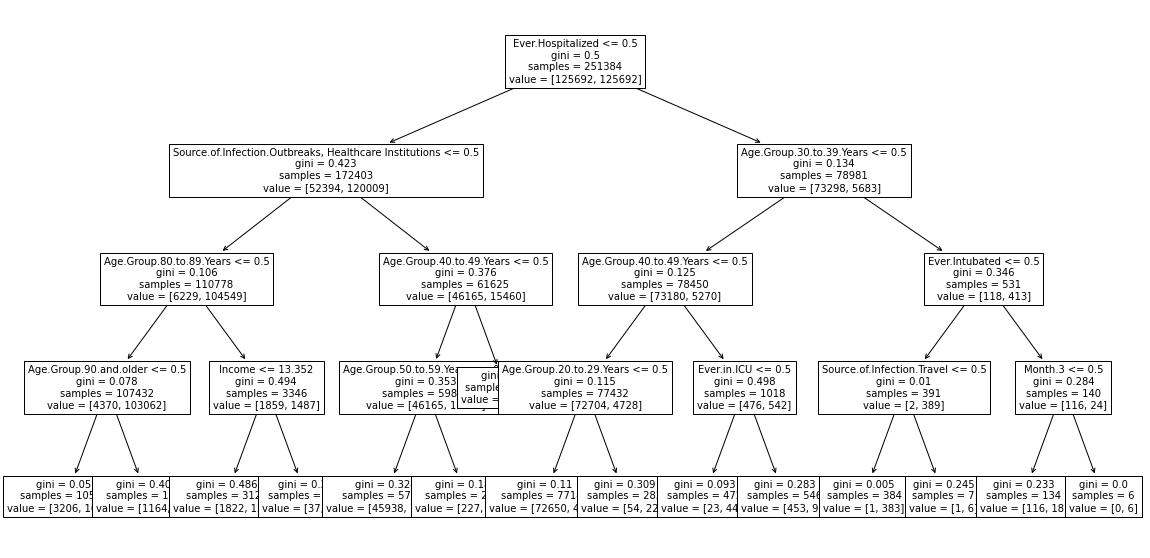

In [160]:
dtc = tree.DecisionTreeClassifier(random_state=0, max_depth=4)
dtc.fit(oversampled_x, oversampled_y)

# Evaluate Model
dtc_eval = evaluate_model(dtc, x_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

plt.figure(figsize=(20,10)) 
tree.plot_tree(dtc, feature_names=feature_names, fontsize=10)
plt.savefig('decision-tree-all-features.pdf')

In [101]:
import xgboost as xgb

### XGBoost

In [102]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(oversampled_x,oversampled_y)

XGBClassifier()

In [103]:
# Evaluate Model
xgb_eval = evaluate_model(xgb_classifier, x_test, y_test)

# Print result
print('Accuracy:', xgb_eval['acc'])
print('Precision:', xgb_eval['prec'])
print('Recall:', xgb_eval['rec'])
print('F1 Score:', xgb_eval['f1'])
print('Cohens Kappa Score:', xgb_eval['kappa'])
print('Area Under Curve:', xgb_eval['auc'])
print('Confusion Matrix:\n', xgb_eval['cm'])

Accuracy: 0.8915030775394253
Precision: 0.9990832951372974
Recall: 0.8902131135367937
F1 Score: 0.9415113973258987
Cohens Kappa Score: 0.22608587179950546
Area Under Curve: 0.9681684451092899
Confusion Matrix:
 [[ 1002    44]
 [ 5914 47954]]


<Figure size 432x288 with 0 Axes>

### All Feature ML Comparison

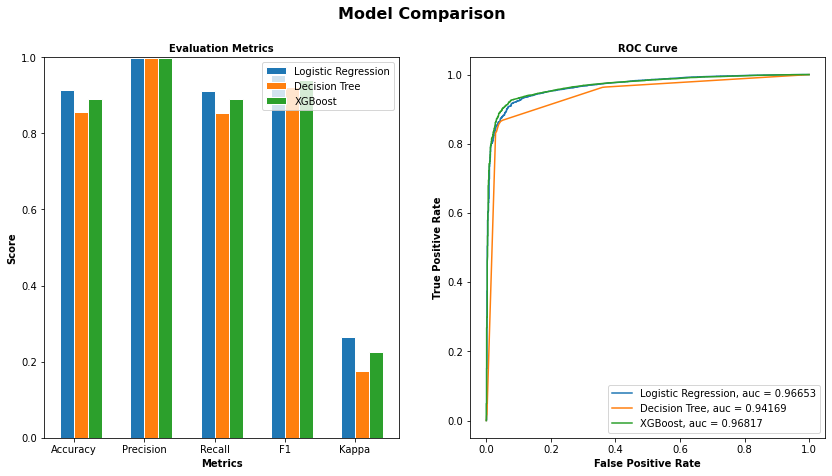

<Figure size 1440x720 with 0 Axes>

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
glm_score = [glm_eval['acc'], glm_eval['prec'], glm_eval['rec'], glm_eval['f1'], glm_eval['kappa']]
xgb_score = [xgb_eval['acc'], xgb_eval['prec'], xgb_eval['rec'], xgb_eval['f1'], xgb_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

## Make the plot
ax1.bar(r2, glm_score, width=barWidth, edgecolor='white', label='Logistic Regression')
ax1.bar(r3, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r4, xgb_score, width=barWidth, edgecolor='white', label='XGBoost')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=10, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(glm_eval['fpr'], glm_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(glm_eval['auc']))
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(xgb_eval['fpr'], xgb_eval['tpr'], label='XGBoost, auc = {:0.5f}'.format(xgb_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=10, fontweight='bold')
ax2.legend(loc=4)

plt.show()
plt.figure(figsize=(20,10)) 
plt.savefig('All Features Model Comparison')

# Feature selection using Chi2

In [105]:
X_dummy = df1.drop(['Outcome'], axis=1)
y_dummy = df1["Outcome"]

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.feature_selection import chi2,SelectKBest

In [107]:
ch2c=SelectKBest(score_func=chi2,k=18)
ch2c.fit(X_dummy,y_dummy)
features_score_pvalue=pd.DataFrame({"Score":ch2c.scores_,"P_Value":np.round(ch2c.pvalues_,3)},index=X_dummy.columns)
features_score_pvalue.nlargest(n=20,columns="Score")

,Score,P_Value
Ever.Hospitalized,20186.313857,0.0
Ever.in.ICU,15257.349183,0.0
Ever.Intubated,14556.374412,0.0
Age.Group.90.and.older,6262.922701,0.0
Age.Group.80.to.89.Years,5928.262025,0.0
"Source.of.Infection.Outbreaks, Healthcare Institutions",5058.402537,0.0
Age.Group.70.to.79.Years,1486.592608,0.0
Outbreak.Associated,678.279570,0.0
Age.Group.20.to.29.Years,605.679563,0.0
Age.Group.19.and.younger,585.076085,0.0


# Selected Features ML

In [132]:
seltarget = df1['Outcome']
selfeature = df1[["Ever.Hospitalized" , "Ever.in.ICU" , "Ever.Intubated" , "Age.Group.90.and.older","Age.Group.80.to.89.Years","Source.of.Infection.Outbreaks, Healthcare Institutions","Age.Group.70.to.79.Years","Outbreak.Associated","Age.Group.20.to.29.Years"]].copy()

In [138]:
selfeature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183045 entries, 0 to 183044
Data columns (total 9 columns):
 #   Column                                                  Non-Null Count   Dtype
---  ------                                                  --------------   -----
 0   Ever.Hospitalized                                       183045 non-null  int64
 1   Ever.in.ICU                                             183045 non-null  int64
 2   Ever.Intubated                                          183045 non-null  int64
 3   Age.Group.90.and.older                                  183045 non-null  int64
 4   Age.Group.80.to.89.Years                                183045 non-null  int64
 5   Source.of.Infection.Outbreaks, Healthcare Institutions  183045 non-null  int64
 6   Age.Group.70.to.79.Years                                183045 non-null  int64
 7   Outbreak.Associated                                     183045 non-null  int64
 8   Age.Group.20.to.29.Years                     

In [139]:
selx_train, selx_test, sely_train, sely_test = train_test_split(selfeature, seltarget, 
                                                    shuffle = True, 
                                                    test_size=0.3, 
                                                    random_state=2)

## SMOTE

In [141]:
selover_x, selover_y = sm.fit_resample(selx_train, sely_train)
selover= pd.concat([pd.DataFrame(selover_y), pd.DataFrame(selover_x)], axis=1)

In [142]:
selover['Outcome'].value_counts()

1    125692
0    125692
Name: Outcome, dtype: int64

### Logistic Regression

In [143]:
sglm = LogisticRegression()
sglm.fit(selover_x,selover_y)

LogisticRegression()

In [146]:
smodel = smt.Logit(selover_y, selover_x)
smodel_fit = smodel.fit()
print(smodel_fit.summary())

Optimization terminated successfully.
         Current function value: 0.253830
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:               251384
Model:                          Logit   Df Residuals:                   251375
Method:                           MLE   Df Model:                            8
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.6338
Time:                        20:39:37   Log-Likelihood:                -63809.
converged:                       True   LL-Null:                   -1.7425e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Ever.Hospitalized  

In [147]:
sglm_eval = evaluate_model(sglm, selover_x, selover_y)

# Print result
print('Accuracy:', sglm_eval['acc'])
print('Precision:', sglm_eval['prec'])
print('Recall:', sglm_eval['rec'])
print('F1 Score:', sglm_eval['f1'])
print('Cohens Kappa Score:', sglm_eval['kappa'])
print('Area Under Curve:', sglm_eval['auc'])
print('Confusion Matrix:\n', sglm_eval['cm'])

Accuracy: 0.9169199312605416
Precision: 0.9248599434098409
Recall: 0.9075756611399294
F1 Score: 0.9161362860642079
Cohens Kappa Score: 0.8338398625210832
Area Under Curve: 0.961123674767224
Confusion Matrix:
 [[116424   9268]
 [ 11617 114075]]


### Decision Tree

In [148]:
sfeature_names = list(selover_x.columns.values)

Accuracy: 0.9053241256404544
Precision: 0.9164909010644038
Recall: 0.891918340069376
F1 Score: 0.9040376752925239
Cohens Kappa Score: 0.8106482512809089
Area Under Curve: 0.9502735356509449
Confusion Matrix:
 [[115477  10215]
 [ 13585 112107]]


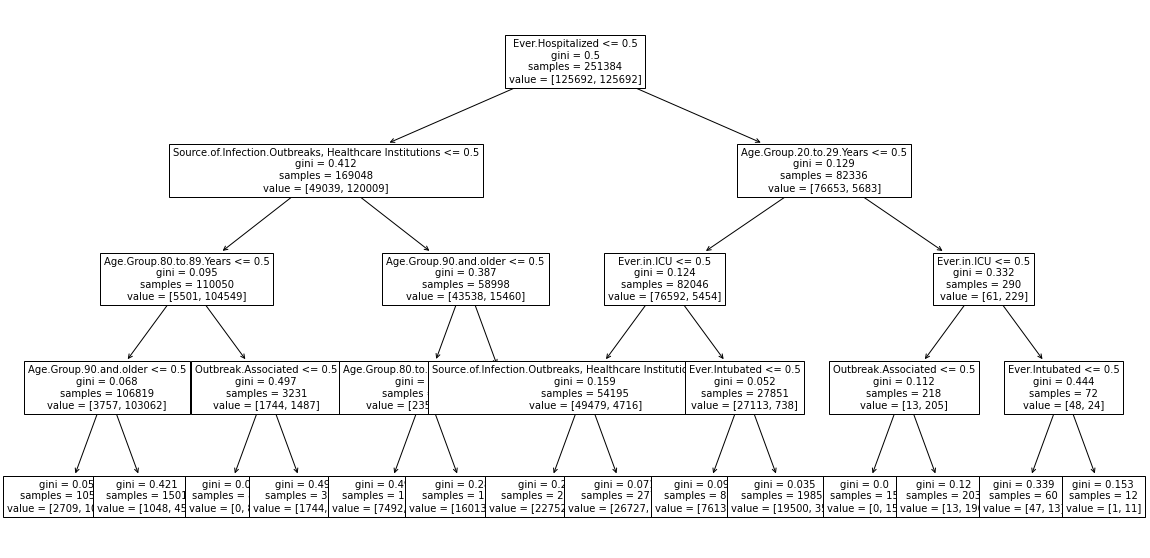

In [149]:
sdtc = tree.DecisionTreeClassifier(random_state=0, max_depth=4)
sdtc.fit(selover_x, selover_y)

# Evaluate Model
sdtc_eval = evaluate_model(sdtc, selover_x, selover_y)

# Print result
print('Accuracy:', sdtc_eval['acc'])
print('Precision:', sdtc_eval['prec'])
print('Recall:', sdtc_eval['rec'])
print('F1 Score:', sdtc_eval['f1'])
print('Cohens Kappa Score:', sdtc_eval['kappa'])
print('Area Under Curve:', sdtc_eval['auc'])
print('Confusion Matrix:\n', sdtc_eval['cm'])

plt.figure(figsize=(20,10)) 
tree.plot_tree(sdtc, feature_names=sfeature_names, fontsize=10)
plt.savefig('selection-decision-tree-all-features.pdf')

### XGBoost

In [151]:
sxgb_classifier = xgb.XGBClassifier()
sxgb_classifier.fit(selover_x, selover_y)

XGBClassifier()

In [152]:
# Evaluate Model
sxgb_eval = evaluate_model(sxgb_classifier, selover_x, selover_y)

# Print result
print('Accuracy:', sxgb_eval['acc'])
print('Precision:', sxgb_eval['prec'])
print('Recall:', sxgb_eval['rec'])
print('F1 Score:', sxgb_eval['f1'])
print('Cohens Kappa Score:', sxgb_eval['kappa'])
print('Area Under Curve:', sxgb_eval['auc'])
print('Confusion Matrix:\n', sxgb_eval['cm'])

Accuracy: 0.9189208541514178
Precision: 0.9558400858785234
Recall: 0.8784250389841836
F1 Score: 0.9154989137825242
Cohens Kappa Score: 0.8378417083028356
Area Under Curve: 0.9614374560206393
Confusion Matrix:
 [[120591   5101]
 [ 15281 110411]]


### Selected Feature ML Comparison

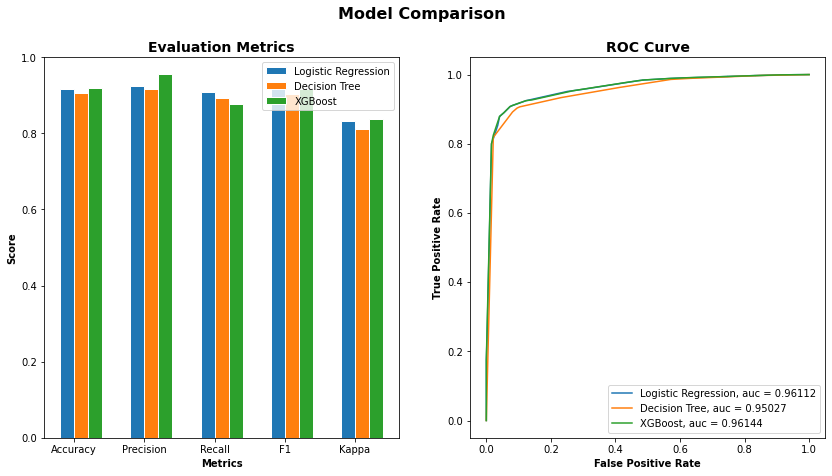

<Figure size 1440x720 with 0 Axes>

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
sdtc_score = [sdtc_eval['acc'], sdtc_eval['prec'], sdtc_eval['rec'], sdtc_eval['f1'], sdtc_eval['kappa']]
sglm_score = [sglm_eval['acc'], sglm_eval['prec'], sglm_eval['rec'], sglm_eval['f1'], sglm_eval['kappa']]
sxgb_score = [sxgb_eval['acc'], sxgb_eval['prec'], sxgb_eval['rec'], sxgb_eval['f1'], sxgb_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(sdtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

## Make the plot
ax1.bar(r2, sglm_score, width=barWidth, edgecolor='white', label='Logistic Regression')
ax1.bar(r3, sdtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r4, sxgb_score, width=barWidth, edgecolor='white', label='XGBoost')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve

ax2.plot(sglm_eval['fpr'], sglm_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(sglm_eval['auc']))
ax2.plot(sdtc_eval['fpr'], sdtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(sdtc_eval['auc']))
ax2.plot(sxgb_eval['fpr'], sxgb_eval['tpr'], label='XGBoost, auc = {:0.5f}'.format(sxgb_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()
plt.show()
plt.figure(figsize=(20,10)) 
plt.savefig('Selected Features Model Comparison')